In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d

from kan import *
from use_training_set import *
import use_KAN
# from use_KAN import *

from lmfit import Minimizer, Parameters, create_params, report_fit, Model


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


## load model

In [2]:
cpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = cpu

In [3]:
# string_setting = "9_7_g_16_16"
string_setting = "10-1_8_g_8_16"
# fname_setup = 'setup_model_13_9.txt'
fname_setup = f'setup_model_{string_setting}.txt'
with open(fname_setup, 'r') as file:
    config = yaml.safe_load(file)
  
use_KAN.update_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)

Device set to: cuda:0
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [4]:
config_file = 'setup_ts.txt'
x_train, y_train, Q_train = load_training_data(config_file, extend=True)
print(x_train.shape)
print(y_train.shape)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)
I_train = np.exp(y_train)

logk_z = x_train[:, 0]
k_z = np.exp(logk_z)
# logk_z = np.log(k_z)
alpha = x_train[:, 2]
logkappa = x_train[:, 1]
kappa = np.exp(logkappa)
# logkappa = np.log(kappa)
set_k_z = np.unique(logk_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique((logkappa)))


k_z in
[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   2.   3.   4.   5.
  6.   7.   8.   9.  10. ]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]
(4000, 3)
(4000, 126)


In [18]:
f_Qx = lambda Q: np.vstack([Q,np.ones_like(Q)]).T
# f_Qx = lambda Q: np.vstack([np.cos(2*np.pi*Q/1),np.cos(2*np.pi*Q/2),np.cos(2*np.pi*Q/4),np.cos(2*np.pi*Q/8),np.cos(2*np.pi*Q/16), np.ones_like(Q)]).T
use_KAN.update_Qx(f_Qx=f_Qx, config=config)

# fname_BR = "./saved_model/KAN/model_13_9_grid_ft_lin_monoc.pth"
fname_BR = f"./saved_model/KAN/model_{string_setting}.pth"
model_KAN.load_state_dict(torch.load(fname_BR))

f_IQ_KAN = lambda model, x, Q: use_KAN.f_IQ_KAN(model, x, Q, f_Qx=f_Qx)

Qx and Qx_inv have been defined and updated.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Model has been redefined.


## load experimental data

In [6]:
def unpack_data(data):
    Q = data[:,0]
    IQ = data[:,1]
    IQ_er = data[:,2]
    # sigma_Q = data[:,3]
    return Q, IQ, IQ_er

In [7]:
## load experimental data
W_list = [30,40,50]
## load D22 data
n_des = 1
data_path = '../../Data/AOT-DesmearedData/'
data_list = []
for W in W_list:
    filename = '{}_des{}.txt'.format(W,n_des)
    data = np.genfromtxt(data_path + filename)
    data_list.append(data)
    # Q = data[:,0]
    # IQ = data[:,1]
    # IQ_er = data[:,2]
    # sigma_Q = data[:,3]

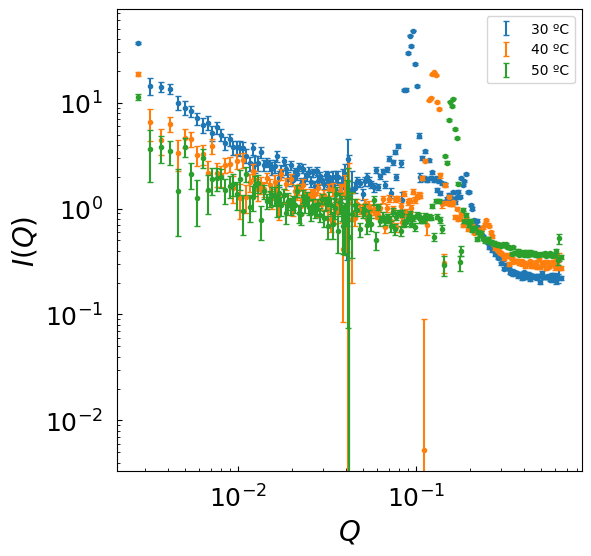

In [8]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']
for i_W, W in enumerate(W_list):
    data = data_list[i_W]
    dataname = '{} ºC'.format(W)
    Q, IQ, IQ_er = unpack_data(data)
    ax.plot(Q,IQ,'.', color = colors[i_W])
    ax.errorbar(Q,IQ,IQ_er,linestyle='',label=dataname, color = colors[i_W] ,capsize=2)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend()

max_Q = 0.64574395
0.09617666
0.12554282
0.16140872


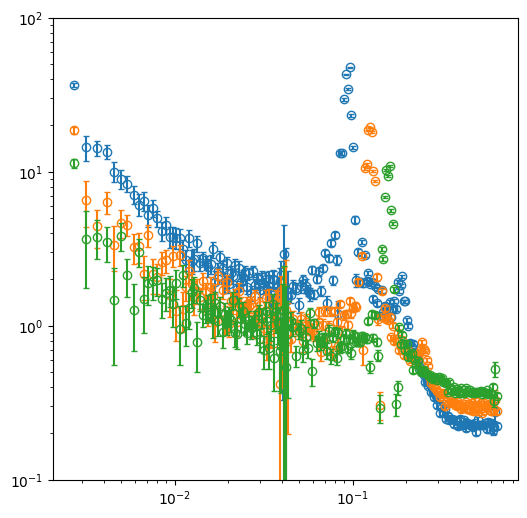

In [9]:
Q_list = []
IQ_list = []
IQ_er_list = []
Q_max_list = []
max_Q = Q[-1]
print('max_Q = {}'.format(max_Q))
delta_Q_list = []

box_size = 2
n_grid_scale = 256
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']
for i_W, W in enumerate(W_list):
    data = data_list[i_W]
    Q, IQ, IQ_er = unpack_data(data)
    Q_list.append(Q)

    ## peak_position
    index_peak_range = Q>4e-2
    Q_peak_range = Q[index_peak_range]
    IQ_peak_range = IQ[index_peak_range]

    index_Q_max = np.argmax(IQ_peak_range)
    Q_max = Q_peak_range[index_Q_max]
    print(Q_max)
    Q_max_list.append(Q_max)

    IQ_list.append(IQ)
    IQ_er_list.append(IQ_er)

    ax.plot(Q, IQ, 'o', label=data[0], color=colors[i_W], fillstyle='none')
    ax.errorbar(Q, IQ, IQ_er,linestyle='',label=dataname, color = colors[i_W] ,capsize=2)

IQ_list = np.array(IQ_list)
IQ_er_list = np.array(IQ_er_list)

ax.set_ylim([1e-1,1e2])

ax.set_yscale('log')
ax.set_xscale('log')

In [10]:
from scipy.special import erf
def volume_fraction(alpha):
    '''
    Evaluate the fraction of water given clipping level alpha
    '''
    return 1-(1+erf(alpha/np.sqrt(2)))/2

## Fit the data

In [11]:
result_list = []

### 30%

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 1306
    # data points      = 89
    # variables        = 6
    chi-square         = 5549.66411
    reduced chi-square = 66.8634230
    Akaike info crit   = 379.824212
    Bayesian info crit = 394.756030
##  Warning: uncertainties could not be estimated:
[[Variables]]
    sigma_k:  0.17963682 (init = 0.2)
    kappa:    4.41922048 (init = 4.2)
    alpha:    0.92797375 (init = 0.7)
    y_scale:  826205.224 (init = 630000)
    x_scale:  0.99904594 (init = 1)
    bg:       0.16883923 (init = 0.15)
volume_fraction = 0.17671059345401585


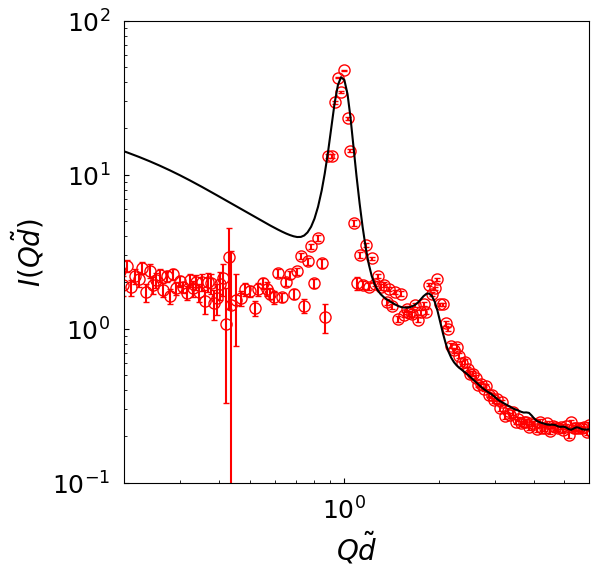

In [12]:
# fitting targets
index_data = 0
IQ_data = IQ_list[index_data]
IQ_er_data = IQ_er_list[index_data]
Q_max = Q_max_list[index_data]
index_Q = (Q/Q_max>0.8)*(Q/Q_max<5)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.2, min=0.1, max=0.3)
params.add('kappa', value=4.2, min=4, max=5)
params.add('alpha', value=0.7, min=0.5, max=1)
params.add('y_scale', value=6.3e5, min=1e5, max=2e6)
params.add('x_scale', value=1.0, min=0.9, max=1.1, vary=True)
params.add('bg', value=0.15, min=0.1, max=0.2)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    x = np.array([np.log(v['sigma_k']),np.log(v['kappa']),v['alpha']])
    x_torch = use_KAN.to_torch_device(x, device=device)
    log_IQ_KAN = f_IQ_KAN(model_KAN, x_torch, Q/v['x_scale'])
    IQ_scaled = np.exp(log_IQ_KAN.cpu().detach().numpy())[0]
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(Q/Q_max, IQ_data, IQ_er_data, index_Q))
# result = minner.minimize('emcee')
result = minner.minimize('powell')
# result = minner.minimize('nelder')
# result = minner.brute(Ns=12)

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))

# fitting targets
index_data = 0
Q_max = Q_max_list[index_data]
# result = result_list[index_data]

IQ_KAN = IQ_th(result.params, Q/Q_max)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(Q/Q_max,IQ_data,'or',fillstyle='none',ms=8)
ax.errorbar(Q/Q_max,IQ_data,IQ_er_data,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(Q/Q_max,IQ_KAN,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,6])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)


### 40%

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 433
    # data points      = 92
    # variables        = 6
    chi-square         = 2827.81803
    reduced chi-square = 32.8816050
    Akaike info crit   = 327.143433
    Bayesian info crit = 342.274165
[[Variables]]
    sigma_k:  0.22199345 +/- 0.00546436 (2.46%) (init = 0.23)
    kappa:    4.27943683 +/- 0.06983289 (1.63%) (init = 4)
    alpha:    0.59432248 +/- 0.00286574 (0.48%) (init = 0.7)
    y_scale:  593100.211 +/- 16342.6073 (2.76%) (init = 630000)
    x_scale:  1.01883507 +/- 0.00218428 (0.21%) (init = 1.1)
    bg:       0.24999985 +/- 2.1902e-05 (0.01%) (init = 0.2)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma_k, x_scale) = -0.5128
    C(kappa, x_scale)   = +0.4502
    C(sigma_k, alpha)   = -0.2750
    C(alpha, x_scale)   = +0.2715
    C(sigma_k, y_scale) = -0.2466
    C(sigma_k, kappa)   = -0.2045
    C(y_scale, bg)      = -0.1122
volume_fraction = 0.2761482214889073


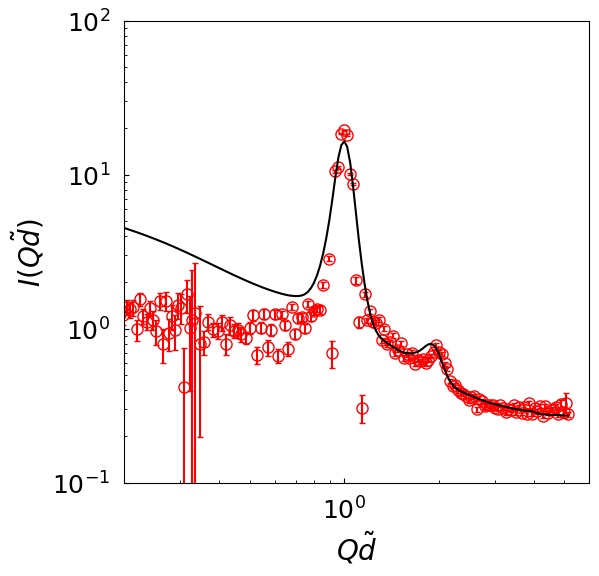

In [13]:
# fitting targets
index_data = 1
IQ_data = IQ_list[index_data]
IQ_er_data = IQ_er_list[index_data]
Q_max = Q_max_list[index_data]
index_Q = (Q/Q_max>0.8)*(Q/Q_max<5)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.23, min=0.05, max=1.0)
params.add('kappa', value=4, min=1, max=12)
params.add('alpha', value=0.7, min=0.5, max=1.0)
params.add('y_scale', value=6.3e5, min=1e5, max=1e6)
params.add('x_scale', value=1.1, min=0.9, max=1.2, vary=True)
params.add('bg', value=0.2, min=0.1, max=0.25)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    x = np.array([np.log(v['sigma_k']),np.log(v['kappa']),v['alpha']])
    x_torch = use_KAN.to_torch_device(x, device=device)
    log_IQ_KAN = f_IQ_KAN(model_KAN, x_torch, Q/v['x_scale'])
    IQ_scaled = np.exp(log_IQ_KAN.cpu().detach().numpy())[0]
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(Q/Q_max, IQ_data, IQ_er_data, index_Q))
# result = minner.minimize('emcee')
result = minner.minimize('powell')
# result = minner.minimize('nelder')
# result = minner.brute(Ns=12)

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))

# fitting targets
Q_max = Q_max_list[index_data]
# result = result_list[index_data]

IQ_KAN = IQ_th(result.params, Q/Q_max)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(Q/Q_max,IQ_data,'or',fillstyle='none',ms=8)
ax.errorbar(Q/Q_max,IQ_data,IQ_er_data,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(Q/Q_max,IQ_KAN,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,6])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)


### 50%

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 1270
    # data points      = 82
    # variables        = 6
    chi-square         = 2619.24427
    reduced chi-square = 34.4637404
    Akaike info crit   = 296.041593
    Bayesian info crit = 310.481908
[[Variables]]
    sigma_k:  0.65068773 +/- 0.00565162 (0.87%) (init = 0.23)
    kappa:    1.63918886 +/- 0.00353315 (0.22%) (init = 1.63)
    alpha:    0.40939838 +/- 0.00146587 (0.36%) (init = 0.26)
    y_scale:  201268.494 +/- 4818.59487 (2.39%) (init = 240000)
    x_scale:  1.00513511 +/- 0.00176337 (0.18%) (init = 1.1)
    bg:       0.33846047 +/- 0.00686204 (2.03%) (init = 0.33)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappa, y_scale)   = -3.2837
    C(kappa, bg)        = -2.7404
    C(kappa, alpha)     = -2.3734
    C(sigma_k, y_scale) = -1.3141
    C(y_scale, x_scale) = +1.2931
    C(x_scale, bg)      = +1.0495
    C(sigma_k, bg)      = -1.0436
    C(alpha, x_scale)   = +0.9697
    C(

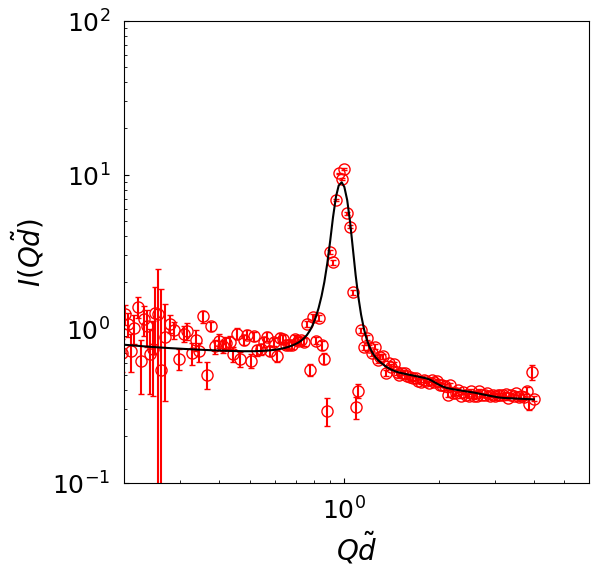

In [14]:
# fitting targets
index_data = 2
IQ_data = IQ_list[index_data]
IQ_er_data = IQ_er_list[index_data]
Q_max = Q_max_list[index_data]
index_Q = (Q/Q_max>0.8)*(Q/Q_max<5)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.23, min=0.05, max=1.0)
params.add('kappa', value=1.63, min=1, max=2)
params.add('alpha', value=0.26, min=0.0, max=1.0)
params.add('y_scale', value=2.4e5, min=2e5, max=1e6)
params.add('x_scale', value=1.1, min=0.9, max=1.2, vary=True)
params.add('bg', value=0.33, min=0.25, max=0.45)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    x = np.array([np.log(v['sigma_k']),np.log(v['kappa']),v['alpha']])
    x_torch = use_KAN.to_torch_device(x, device=device)
    log_IQ_KAN = f_IQ_KAN(model_KAN, x_torch, Q/v['x_scale'])
    IQ_scaled = np.exp(log_IQ_KAN.cpu().detach().numpy())[0]
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(Q/Q_max, IQ_data, IQ_er_data, index_Q))
# result = minner.minimize('emcee')
result = minner.minimize('powell')
# result = minner.minimize('nelder')
# result = minner.brute(Ns=12)

# write error report
report_fit(result)
result_list.append(result)
v_result = result.params.valuesdict()
print('volume_fraction = {}'.format(volume_fraction(v_result['alpha'])))

# fitting targets
Q_max = Q_max_list[index_data]
# result = result_list[index_data]

IQ_KAN = IQ_th(result.params, Q/Q_max)

## plot fitting results
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(Q/Q_max,IQ_data,'or',fillstyle='none',ms=8)
ax.errorbar(Q/Q_max,IQ_data,IQ_er_data,
            linestyle='',label=dataname, color = 'r' ,capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(Q/Q_max,IQ_KAN,'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.2,6])
ax.set_ylim([0.1,100])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
